# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


/tmp/ipykernel_17547/384002432.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Data/Training/pair_features_1_pairs1_300_120.csv')
df.head()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,REG,2001-02-09 00:00:00,24.050,23.910,16100.000,8.682,COO,4.839,4.801,883200.000,4.716,3.965,3.308,0.464,3.737,0.217,0.032,3.861,0.315
1,REG,2001-02-12 00:00:00,24.500,24.000,44400.000,8.885,COO,4.869,4.713,1195200.000,4.631,4.254,3.311,0.467,3.781,0.227,0.045,3.828,0.306
2,REG,2001-02-13 00:00:00,24.470,23.900,47600.000,8.733,COO,4.780,4.531,1394400.000,4.441,4.292,3.314,0.470,3.822,0.243,0.050,3.796,0.289
3,REG,2001-02-14 00:00:00,24.350,23.930,51600.000,8.769,COO,4.575,4.363,2244000.000,4.322,4.447,3.318,0.475,3.856,0.279,0.000,3.754,0.249
4,REG,2001-02-15 00:00:00,24.280,23.800,129800.000,8.744,COO,4.512,4.425,1223200.000,4.377,4.366,3.321,0.478,3.894,0.295,0.000,3.710,0.213


In [3]:
total_days = df.Date.nunique()
total_days

5738

In [4]:
df.pnls.describe()

count   5738.000
mean       0.001
std        0.026
min       -0.199
25%        0.000
50%        0.000
75%        0.000
max        0.311
Name: pnls, dtype: float64

### Beta

In [5]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

2

### Single Ticker Features

In [6]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls', 'actual_abs_spread',
       'actual_abs_spread_std'],
      dtype='object')

In [7]:
df.sort_values('Date')

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,REG,2001-02-09 00:00:00,24.050,23.910,16100.000,8.682,COO,4.839,4.801,883200.000,4.716,3.965,3.308,0.464,3.737,0.217,0.032,3.861,0.315
1,REG,2001-02-12 00:00:00,24.500,24.000,44400.000,8.885,COO,4.869,4.713,1195200.000,4.631,4.254,3.311,0.467,3.781,0.227,0.045,3.828,0.306
2,REG,2001-02-13 00:00:00,24.470,23.900,47600.000,8.733,COO,4.780,4.531,1394400.000,4.441,4.292,3.314,0.470,3.822,0.243,0.050,3.796,0.289
3,REG,2001-02-14 00:00:00,24.350,23.930,51600.000,8.769,COO,4.575,4.363,2244000.000,4.322,4.447,3.318,0.475,3.856,0.279,0.000,3.754,0.249
4,REG,2001-02-15 00:00:00,24.280,23.800,129800.000,8.744,COO,4.512,4.425,1223200.000,4.377,4.366,3.321,0.478,3.894,0.295,0.000,3.710,0.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,REG,2023-11-24 00:00:00,61.470,61.000,257100.000,60.681,COO,84.988,84.130,288400.000,84.835,24.154,25.722,8.231,22.429,1.914,0.000,22.846,1.799
5734,REG,2023-11-27 00:00:00,62.150,60.900,538900.000,61.116,COO,84.688,83.660,1437600.000,83.765,22.649,25.741,8.217,22.580,1.798,-0.000,23.065,2.015
5735,REG,2023-11-28 00:00:00,61.930,61.280,665600.000,61.205,COO,84.305,83.195,975200.000,83.585,22.380,25.760,8.203,22.710,1.675,-0.005,23.343,2.268
5736,REG,2023-11-29 00:00:00,62.860,61.370,856600.000,60.829,COO,84.375,82.548,1398800.000,82.897,22.069,25.777,8.189,22.898,1.330,-0.000,23.601,2.399


In [8]:
label = 'actual_abs_spread'
features_to_exclude = [] # ['High_P1', 'High_P2', 'Low_P1', 'Low_P2', 'abs_spread', 'abs_spread_mean', 'abs_spread_std']
always_exclude = ['pnls', 'actual_abs_spread_std']
X = df
y = df[label]

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
X = X.drop(always_exclude, axis=1)
X = X.drop(features_to_exclude, axis=1)

In [9]:
X = X.dropna()
X['abs_spread_log_mean_MA'] = np.log(X['abs_spread_mean_MA'])
X['abs_spread_log_std_mean_MA'] = np.log(X['abs_spread_std_MA'])
X = X.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)
X

,High_P1,Low_P1,Close_P1,High_P2,Low_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_log_mean_MA,abs_spread_log_std_mean_MA
0,24.050,23.910,8.682,4.839,4.801,4.716,3.965,3.308,0.464,1.318,-1.529
1,24.500,24.000,8.885,4.869,4.713,4.631,4.254,3.311,0.467,1.330,-1.482
2,24.470,23.900,8.733,4.780,4.531,4.441,4.292,3.314,0.470,1.341,-1.416
3,24.350,23.930,8.769,4.575,4.363,4.322,4.447,3.318,0.475,1.350,-1.276
4,24.280,23.800,8.744,4.512,4.425,4.377,4.366,3.321,0.478,1.359,-1.221
...,...,...,...,...,...,...,...,...,...,...,...
5733,61.470,61.000,60.681,84.988,84.130,84.835,24.154,25.722,8.231,3.110,0.649
5734,62.150,60.900,61.116,84.688,83.660,83.765,22.649,25.741,8.217,3.117,0.587
5735,61.930,61.280,61.205,84.305,83.195,83.585,22.380,25.760,8.203,3.123,0.516
5736,62.860,61.370,60.829,84.375,82.548,82.897,22.069,25.777,8.189,3.131,0.286


In [10]:
y = np.log(y)
y.describe()

count   5738.000
mean       2.381
std        0.894
min       -1.283
25%        1.847
50%        2.457
75%        3.052
max        3.982
Name: actual_abs_spread, dtype: float64

## Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [12]:
print(df.loc[X_train.index].Date.min(),df.loc[X_train.index].Date.max())

2001-02-09 00:00:00 2019-05-10 00:00:00


In [13]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-05-13 00:00:00 2021-08-19 00:00:00


In [14]:
print(df.loc[X_test.index].Date.min(),df.loc[X_test.index].Date.max())

2021-08-20 00:00:00 2023-11-30 00:00:00


## LSTM Model

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.lstm = LSTM(512, input_shape=self.shape, dropout=0.2, return_sequences = True)
        self.dropout = Dropout(0.2)
        self.dense = Dense(1)

    def call(self, x):
        x = self.lstm(x)
#         x = self.dropout(x)
        x = self.dense(x)
        return x

2024-03-21 00:49:02.229377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 00:49:02.984090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])).astype(np.float32)
testX = np.reshape(X_test, ( X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [17]:
trainX.shape

(4590, 1, 11)

In [18]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[0], 1, trainX.shape[1]))
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train,
                    validation_data=(valX, y_val), 
                    epochs=50, 
                    batch_size=32,
                    verbose=1, 
                    callbacks=callback,
                    shuffle=False)       

Epoch 1/50


2024-03-21 00:49:03.796339: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


144/144 [==============================] - 3s 14ms/step - loss: 1.5243 - mae: 1.5243 - val_loss: 1.8371 - val_mae: 1.8371
Epoch 2/50
144/144 [==============================] - 2s 12ms/step - loss: 0.7370 - mae: 0.7370 - val_loss: 1.1941 - val_mae: 1.1941
Epoch 3/50
144/144 [==============================] - 2s 12ms/step - loss: 0.5961 - mae: 0.5961 - val_loss: 0.9878 - val_mae: 0.9878
Epoch 4/50
144/144 [==============================] - 2s 12ms/step - loss: 0.5312 - mae: 0.5312 - val_loss: 0.8731 - val_mae: 0.8731
Epoch 5/50
144/144 [==============================] - 2s 12ms/step - loss: 0.4932 - mae: 0.4932 - val_loss: 0.7412 - val_mae: 0.7412
Epoch 6/50
144/144 [==============================] - 2s 12ms/step - loss: 0.4503 - mae: 0.4503 - val_loss: 0.6057 - val_mae: 0.6057
Epoch 7/50
144/144 [==============================] - 2s 12ms/step - loss: 0.4387 - mae: 0.4387 - val_loss: 0.5384 - val_mae: 0.5384
Epoch 8/50
144/144 [==============================] - 2s 12ms/step - loss: 0.420

In [19]:
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  1073152   
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 dense (Dense)               multiple                  513       
                                                                 
Total params: 1073665 (4.10 MB)
Trainable params: 1073665 (4.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


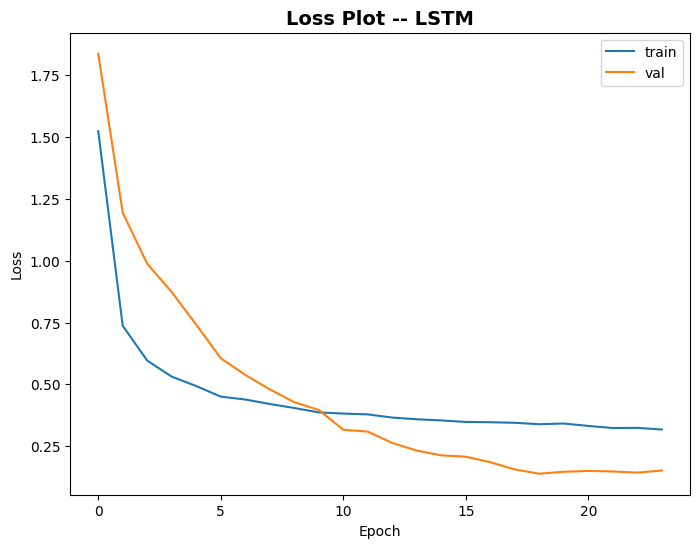

In [20]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
inference_result = lstm_model.predict(testX).flatten()

18/18 [==============================] - 0s 2ms/step


count   574.000
mean      3.286
std       0.330
min       2.394
25%       3.069
50%       3.296
75%       3.543
max       3.912
Name: actual_abs_spread, dtype: float64

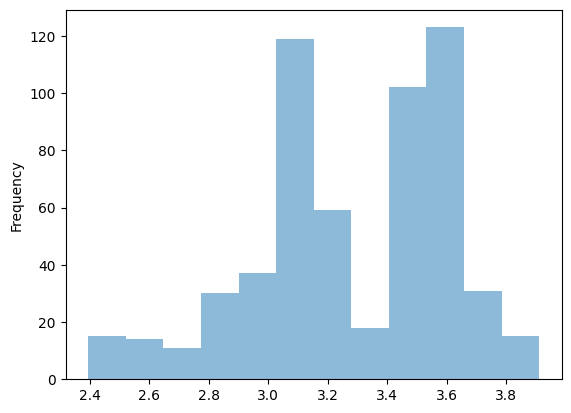

In [22]:
y_test.plot.hist(bins=12, alpha=0.5)
y_test.describe()

count   574.000
mean      3.178
std       0.288
min       2.398
25%       2.961
50%       3.198
75%       3.389
max       3.809
dtype: float64

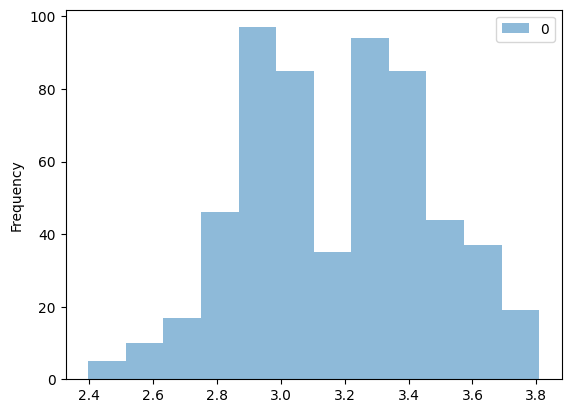

In [23]:
pd.DataFrame(inference_result).plot.hist(bins=12, alpha=0.5)
pd.Series(inference_result).describe()

In [24]:
lstm_mae = (inference_result[:len(y_test)] - y_test).abs().mean()
lstm_mae

0.1544768052750938

In [25]:
inference_result

array([3.8067098, 3.8021488, 3.808556 , 3.783166 , 3.7826815, 3.7626777,
       3.7739134, 3.7779922, 3.7672052, 3.7567885, 3.7823052, 3.7388403,
       3.777443 , 3.7199483, 3.783913 , 3.719895 , 3.708383 , 3.7061849,
       3.6786723, 3.667819 , 3.6666634, 3.6527948, 3.6841948, 3.698529 ,
       3.6878648, 3.6479812, 3.6278396, 3.5950985, 3.5939631, 3.5613375,
       3.5062785, 3.5611753, 3.5529034, 3.5266535, 3.5043166, 3.466226 ,
       3.4487681, 3.4377544, 3.4297774, 3.3966851, 3.3707151, 3.454272 ,
       3.4676318, 3.4890032, 3.5205445, 3.491559 , 3.4714313, 3.4484572,
       3.4827065, 3.4917278, 3.5043154, 3.4528084, 3.4072075, 3.397534 ,
       3.3634133, 3.479285 , 3.4887035, 3.4714973, 3.3576195, 3.3728547,
       3.3565521, 3.364927 , 3.3353157, 3.301972 , 3.323771 , 3.3103688,
       3.2929165, 3.23637  , 3.263023 , 3.2850974, 3.2966986, 3.300891 ,
       3.2299027, 3.3349037, 3.3303816, 3.330215 , 3.3731627, 3.3686543,
       3.322522 , 3.2827497, 3.3104854, 3.3460317, 

In [26]:
mae = lstm_mae / y_test.abs().mean()
mae

0.04700446276652231

In [27]:
# Generate the PNL from predicted spread
from pair_trading_foundations.data_generation import ExecutePairTrading

BacktestData = df.loc[X_test.index]

samples = BacktestData
samples = samples.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
samples = samples.drop(always_exclude,axis=1)
samples = samples.drop(features_to_exclude,axis=1)
samples['abs_spread_log_mean_MA'] = np.log(samples.abs_spread_mean_MA)
samples['abs_spread_log_std_mean_MA'] = np.log(samples.abs_spread_std_MA)
samples = samples.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)


model_input = np.reshape(samples, (samples.shape[0], 1, samples.shape[1])).astype(np.float32)
inference_result = lstm_model.predict(model_input).flatten()
BacktestData['pred_abs_spread'] = np.exp(inference_result)
BacktestData['z_score'] = (np.log(BacktestData['pred_abs_spread']) / BacktestData['abs_spread_std_MA'])
BacktestData = BacktestData.reset_index(drop=True)
BacktestData = BacktestData.drop(['actual_abs_spread', 'actual_abs_spread_std'], axis=1)
BacktestData 

18/18 [==============================] - 0s 2ms/step


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,pred_abs_spread,z_score
0,REG,2021-08-20 00:00:00,65.120,63.200,586800.000,58.647,COO,111.452,109.967,2160800.000,111.008,52.361,44.200,6.083,46.648,3.608,0.000,45.002,1.055
1,REG,2021-08-23 00:00:00,65.510,64.750,476100.000,58.810,COO,111.640,110.588,900000.000,111.173,52.363,44.271,6.054,47.130,3.698,0.000,44.797,1.028
2,REG,2021-08-24 00:00:00,65.590,64.760,635300.000,59.207,COO,112.500,111.050,789200.000,111.910,52.702,44.338,6.035,47.594,3.789,0.000,45.085,1.005
3,REG,2021-08-25 00:00:00,67.320,65.160,886700.000,60.663,COO,112.497,110.952,604000.000,111.647,50.984,44.391,6.024,47.895,3.808,0.000,43.955,0.993
4,REG,2021-08-26 00:00:00,67.210,66.300,1024400.000,60.365,COO,111.675,110.855,772400.000,111.480,51.115,44.444,6.013,48.193,3.816,0.000,43.934,0.991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,REG,2023-11-24 00:00:00,61.470,61.000,257100.000,60.681,COO,84.988,84.130,288400.000,84.835,24.154,25.722,8.231,22.429,1.914,0.000,20.222,1.571
570,REG,2023-11-27 00:00:00,62.150,60.900,538900.000,61.116,COO,84.688,83.660,1437600.000,83.765,22.649,25.741,8.217,22.580,1.798,-0.000,19.293,1.646
571,REG,2023-11-28 00:00:00,61.930,61.280,665600.000,61.205,COO,84.305,83.195,975200.000,83.585,22.380,25.760,8.203,22.710,1.675,-0.005,19.065,1.760
572,REG,2023-11-29 00:00:00,62.860,61.370,856600.000,60.829,COO,84.375,82.548,1398800.000,82.897,22.069,25.777,8.189,22.898,1.330,-0.000,18.936,2.211


In [28]:
pnls = []
entry_signal = 2    # Make sure this matches with data pipeline
exit_signal = 0.5   # Make sure this matches with data pipeline
test_len = 20       # Make sure this matches with data pipeline
for idx in range(BacktestData.shape[0]):
    if (idx > BacktestData.shape[0]-test_len-1):
        pnls.append(np.nan)
    else:
        current_row = BacktestData.loc[idx]
        result = ExecutePairTrading(current_row.pred_abs_spread,   # Use predicted spread
                                    current_row.abs_spread_std_MA, # Use current std deviation
                                    entry_signal=entry_signal,
                                    exit_signal=exit_signal
                                ).execute(
                                    # Forward window
                                    vec1=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P1'].values,
                                    vec2=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P2'].values,
                                    dates=BacktestData.loc[(idx+1):(idx+test_len)]['Date'].values,
                                    base_fund=100,
                                )

        pnls.append(result.final_pl_pct)

BacktestData['pred_pnls'] = pnls
BacktestData = BacktestData.dropna()

strategy = BacktestData.loc[(abs(BacktestData['z_score']) > 0.95) & (BacktestData['pred_pnls'] > 0)]
strategy

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,pred_abs_spread,z_score,pred_pnls
2,REG,2021-08-24 00:00:00,65.590,64.760,635300.000,59.207,COO,112.500,111.050,789200.000,111.910,52.702,44.338,6.035,47.594,3.789,0.000,45.085,1.005,0.037
3,REG,2021-08-25 00:00:00,67.320,65.160,886700.000,60.663,COO,112.497,110.952,604000.000,111.647,50.984,44.391,6.024,47.895,3.808,0.000,43.955,0.993,0.038
4,REG,2021-08-26 00:00:00,67.210,66.300,1024400.000,60.365,COO,111.675,110.855,772400.000,111.480,51.115,44.444,6.013,48.193,3.816,0.000,43.934,0.991,0.038
6,REG,2021-08-30 00:00:00,68.330,67.360,1051400.000,61.657,COO,113.757,111.777,777200.000,112.307,50.650,44.543,5.987,48.543,3.837,0.000,43.550,0.984,0.021
7,REG,2021-08-31 00:00:00,69.080,68.110,1493900.000,62.037,COO,112.878,111.152,1404800.000,112.640,50.602,44.594,5.972,48.682,3.860,0.000,43.728,0.979,0.039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,REG,2023-10-06 00:00:00,58.420,57.170,1579400.000,57.385,COO,78.967,76.338,1875600.000,78.365,20.980,25.452,8.406,21.994,1.314,0.000,18.764,2.232,0.027
536,REG,2023-10-09 00:00:00,58.950,57.510,1434100.000,58.038,COO,78.695,77.143,1934800.000,77.702,19.664,25.447,8.409,21.711,1.159,0.000,17.715,2.480,0.010
537,REG,2023-10-10 00:00:00,59.520,58.380,1106900.000,58.315,COO,79.253,77.537,1206800.000,79.030,20.715,25.445,8.410,21.549,1.049,0.012,18.223,2.766,0.027
538,REG,2023-10-11 00:00:00,60.240,59.210,997400.000,59.345,COO,78.870,76.830,1151600.000,77.688,18.343,25.431,8.419,21.276,1.139,0.012,16.888,2.481,0.022


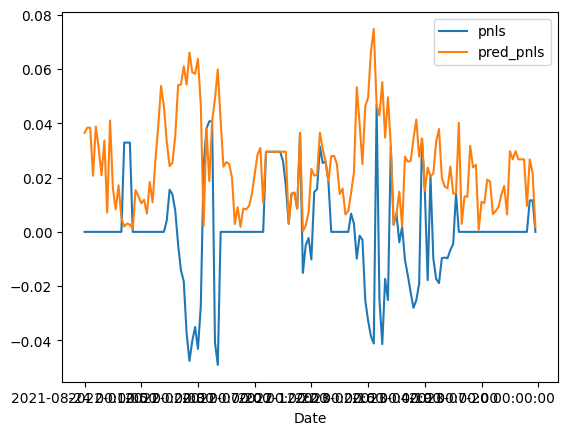

<Figure size 800x600 with 0 Axes>

In [29]:
pnl_filters = strategy.filter(items=['Date', 'pnls', 'pred_pnls'])
pnl_filters.plot('Date',y=['pnls','pred_pnls'])
plt.figure(figsize=(8,6))
plt.show()

In [43]:
actual_total_pnl = pnl_filters.pnls.sum()
print('Returns: ', actual_total_pnl)

Returns:  0.03977533994461738


In [30]:
# Normality test

from scipy.stats import shapiro
# normality test
stat, p = shapiro(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)


In [31]:
# D’Agostino’s K^2 Test
from scipy.stats import normaltest
# normality test
stat, p = normaltest(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=22.371, p=0.000
Sample does not look Gaussian (reject H0)


In [32]:
# Anderson-Darling Test
from scipy.stats import anderson
result = anderson(inference_result)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
if result.statistic < result.critical_values[i]:
    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
else:
    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 4.590
1.000: 1.085, data does not look normal (reject H0)
